In [1]:
# instalar versión 3.3.0.10 de OpenCV
!pip install opencv-python==3.3.0.10 opencv-contrib-python==3.3.0.10
print('\nSi se muestra esto es porque ya está instalado!')

     |████████████████████████████████| 15.5MB 1.6MB/s 
     |████████████████████████████████| 21.4MB 1.2MB/s 
ERROR: dopamine-rl 1.0.5 has requirement opencv-python>=3.4.1.15, but you'll have opencv-python 3.3.0.10 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30

Si se muestra esto es porque ya está instalado!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
pri1 = True
pri = False
plot1 = True
plot = False

def saturacion(imagen_hsv):
  #mostrar la imagne HSV suavizada
  #fig = plt.figure(figsize=(10, 10))
  #plt.imshow(imagen_hsv)
  #plt.axis('off')
  #plt.show()

  #preparando arreglo con imagen de intensidades 
  intensidades = np.zeros((len(imagen_hsv), len(imagen_hsv[0])), dtype='uint8')
  
  #creando arreglo que contendra los valores de la maximas intensidades
  # encontradas
  area_max = np.uint(len(imagen_hsv[0])*len(imagen_hsv)* 0.20)
  maximos = np.zeros(area_max, dtype= "uint8")

  #Recorriendo imagen HSV para encontrar puntos con alta saturacion o intensidad
  pos_max = [0,0]
  maximo = 0
  for i in range(len(imagen_hsv)):
    for j in range(len(imagen_hsv[0])):
      intensidades[i][j] = imagen_hsv[i][j][1]
      valor = imagen_hsv[i][j][1]
      minimo = np.min(maximos)
      if(valor > minimo):
        for k in range(len(maximos)):
          if maximos[k] == minimo:
            maximos[k] = valor
            break
      if(valor > maximo):
        maximo = valor
        pos_max[0], pos_max[1] = i , j
    max_intensidad = np.mean(maximos)

  img_mask = cv2.inRange(intensidades, np.int(0.6 * np.min(maximos)), 255)/255
  
  #mostrar intensidades 
  #fig = plt.figure(figsize=(10, 10))
  #plt.imshow(intensidades, cmap='gray')
  #plt.axis('off')
  #plt.show()

  if(plot == True):
    fig = plt.figure(figsize= (10, 10))
    plt.imshow(img_mask, cmap="gray")
    plt.axis('off')

  return img_mask, pos_max[0], pos_max[1]

In [ ]:
def pos_labels(labels, n_label, centro):
  """Este funcion busca una etiqueta interesante con el criterio de que esta este
  lo mas cercano a la posicion de donde se cree que debería de haber una luz y
  que ademas la etiqueta tenga un minimo de pixeles, esto con la idea de que no
  registre etiquetas que pueden ser simplemente ruido"""
  n_min_pixeles = 17 # Indica el minimo de pixeles que puede tener una etiqueta 
                     # "interesante"
  x_centro, y_centro = centro[0], centro[1] # Cordenadas del lugar donde se cree
                                            # que se deberia de ubicar la luz
  dist_max = 20
  x_prom = 0 # Guarda posicion x de la etiqueta 
  y_prom = 0 # Guarda posicion y de la etiqueta 
  n_pixeles = 0 # Guarda numero de pixeles que contiene la etiqueta
  posiciones = np.zeros((n_label-1, 4), dtype='int') # Arreglo que guardara la
                                                       # posicion de las etiqueta 
                                                       # en los primeros 2 terminos
                                                       # en el tercero se guarda el
                                                       # numero de pixeles y en el 
                                                       # ultimo se guarda el numero 
                                                       # de etiqueta
  # En este for se ubica el centro de masa de cada etiqueta
  for i in range(1, n_label):
    lab_act = np.uint(labels == i)
    for j in range(len(lab_act)):
      for k in range(len(lab_act[0])):
        if(lab_act[j][k] != 0):
          x_prom += j
          y_prom += k
          n_pixeles += 1
          
    posiciones[i-1][0] = np.int(x_prom/n_pixeles)
    posiciones[i-1][1] = np.int(y_prom/n_pixeles)
    posiciones[i-1][2] = n_pixeles
    posiciones[i-1][3] = i
    n_pixeles = 0

  # Buscando las etiquetas mas "interesantes"

  cord_min = [len(labels), len(labels)] # Cordenadas donde se guardara la 
                                        # etiqueta más interesante se inicia 
                                        # con valores intencionalmente altos
  n_pixeles_min = 0 # Variable que contendra el numero de pixeles de la etiqueta
                    # "interesante"
  label_min = 0 # Variable que contiene el numero de la etiqueta "interesante"

  # Buscando entre las etiquetas encontradas la mas cercana a la posicion 
  # donde se cree que deberia de estar la luz y que ademas que tenga un numero
  # de pixeles mayor a n_min_pixeles
  for i in range(len(posiciones)):
    dist_min = np.sqrt((cord_min[0]**2) + (cord_min[1]**2))

    if(posiciones[i][2]> n_min_pixeles):
      cuad1 = float((posiciones[i][0] - x_centro)**2)
      cuad2 = float((posiciones[i][1] - y_centro)**2)
      dist_act = np.sqrt(cuad1 + cuad2)

      if((dist_act < dist_min) and (dist_act < dist_max)):
        cord_min[0], cord_min[1] = posiciones[i][0], posiciones[i][1]
        n_pixeles_min = posiciones[i][2]
        label_min = posiciones[i][3]

  return n_pixeles_min, label_min, cord_min

In [ ]:
def f_color(img_mask_color):

  #Ploteando la imagen recibida:
  if(plot == True):
    print("Printeando la mascara")
    plt.figure(figsize=(10, 10))
    plt.imshow(img_mask_color)
    plt.axis('off')
    plt.show()

  #Contar la cantidad de pixeles verdes amarillos y rojos
  num_verde = 0
  num_amarillo = 0
  num_rojo = 0
  rad_max = 20
  alto = len(img_mask_color)
  ancho = len(img_mask_color[0])


  mat_v = np.zeros((np.uint(alto/2),ancho), dtype='uint8')
  mat_a = np.zeros((np.uint(alto/2),ancho), dtype='uint8')
  mat_r = np.zeros((np.uint(alto/2),ancho), dtype='uint8')
  com_v = int(alto/2 )
  com_r = 0
  com_a = int(alto/4)
  centro_v = [np.int(alto/4), np.int(ancho/2)]
  centro_a = [np.int(alto/4), np.int(ancho/2)]
  centro_r = [np.int(alto/4), np.int(ancho/2)]
  print("El centro verde es: " + str(centro_v))
  for i in range(len(img_mask_color)):
    for j in range(len(img_mask_color[0])):
      R = img_mask_color[i][j][0]
      G = img_mask_color[i][j][1]
      B = img_mask_color[i][j][2]

      #viendo si pixel es verde

      if(i >= com_v and (i - com_v) < np.uint(alto/2)):
        pos_act_x = i- com_v
        pos_act_y = j
        dist = np.sqrt(((pos_act_x - centro_v[0])**2) + ((pos_act_y - centro_v[1])**2))
        esta_dentro = dist < rad_max
        if(R < 130 and G > 100 and B < 180 and esta_dentro):
          num_verde += 1
          mat_v[i - com_v][j] = 255 

      #viendo si pixel es amarillo
      if(i >= com_a and (i - com_a) < np.uint(alto/2)):
        pos_act_x = i- com_a
        pos_act_y = j
        dist = np.sqrt(((pos_act_x - centro_a[0])**2) + ((pos_act_y - centro_a[1])**2))
        esta_dentro = dist < (rad_max * 0.80)
        if(R > 150 and G > 80 and B < 77 and esta_dentro):
          num_amarillo += 1
          mat_a[i - com_a][j] = 255 

      #viendo si pixel es rojo
      if(i >= com_r and (i - com_r) < np.uint(alto/2)):
        pos_act_x = i- com_r
        pos_act_y = j
        dist = np.sqrt(((pos_act_x - centro_r[0])**2) + ((pos_act_y - centro_r[1])**2))
        esta_dentro = dist < rad_max
        if(R > 140 and G < 100 and B < 80 and esta_dentro):
          num_rojo += 1
          mat_r[i - com_r][j] = 255

  if(plot == True):
    print("Printeando la mascara amarilla")
    plt.figure(figsize=(10, 10))
    plt.imshow(mat_a, cmap='gray')
    plt.axis('off')
    plt.show()
  n_lab_v, lab_v = cv2.connectedComponents(mat_v)
  n_lab_a, lab_a = cv2.connectedComponents(mat_a)
  n_lab_r, lab_r = cv2.connectedComponents(mat_r)
  n_pix_v, lab_min_v, cord_min_v = pos_labels(lab_v, n_lab_v, centro_v)
  n_pix_a, lab_min_a, cord_min_a = pos_labels(lab_a, n_lab_a, centro_a)
  n_pix_r, lab_min_r, cord_min_r = pos_labels(lab_r, n_lab_r, centro_r)

  print("La luz verde es: ")
  label_est = np.uint8(lab_v == lab_min_v)
  plt.figure(figsize=(10, 10))
  plt.imshow(label_est, cmap='gray')
  plt.axis('off')
  plt.show()

  print("La luz amarilla es: ")
  label_est = np.uint8(lab_a == lab_min_a)
  plt.figure(figsize=(10, 10))
  plt.imshow(label_est, cmap='gray')
  plt.axis('off')
  plt.show()

  print("La luz roja es: ")
  label_est = np.uint8(lab_r == lab_min_r)
  plt.figure(figsize=(10, 10))
  plt.imshow(label_est, cmap='gray')
  plt.axis('off')
  plt.show()

  


  if(pri1 == True):
    print("El numero de verdes es: " + str(n_pix_v))
    print("El numero de amarillos es: " + str(n_pix_a))
    print("El numero de rojos es: " + str(n_pix_r))
  return n_pix_v, n_pix_a, n_pix_r


  return 0
  #----------------------------------------#
  #------------FALTA TERMINAR--------------#
  #----------------------------------------#

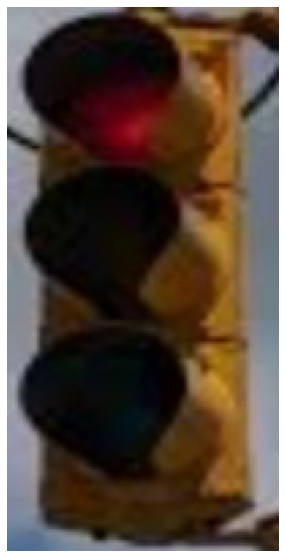

El color es: 
[108, 1, 20]
La posicion es: 
45 38
[49 33 12]
El centro verde es: [50, 50]
La luz verde es: 


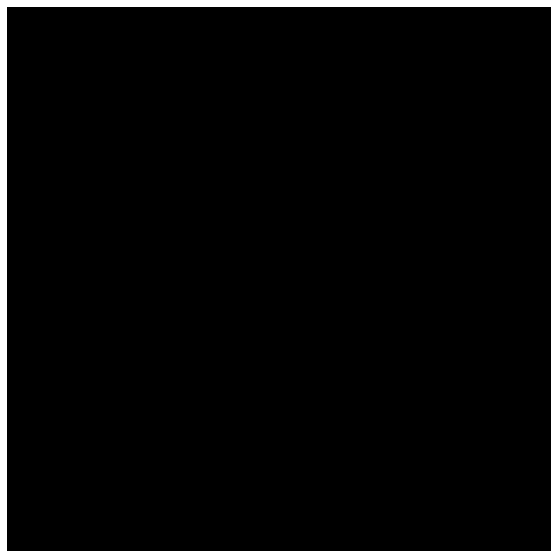

La luz amarilla es: 


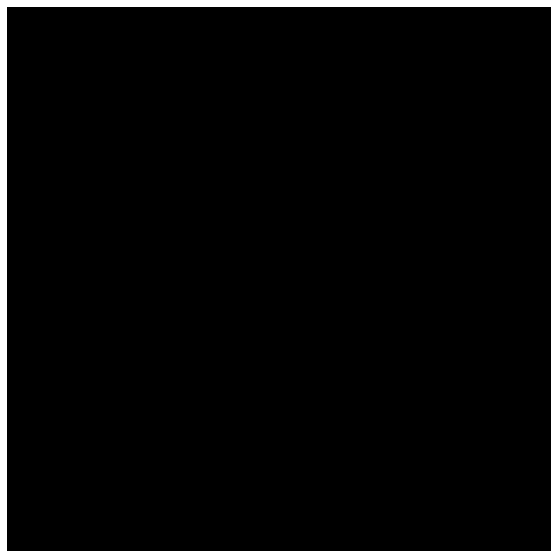

La luz roja es: 


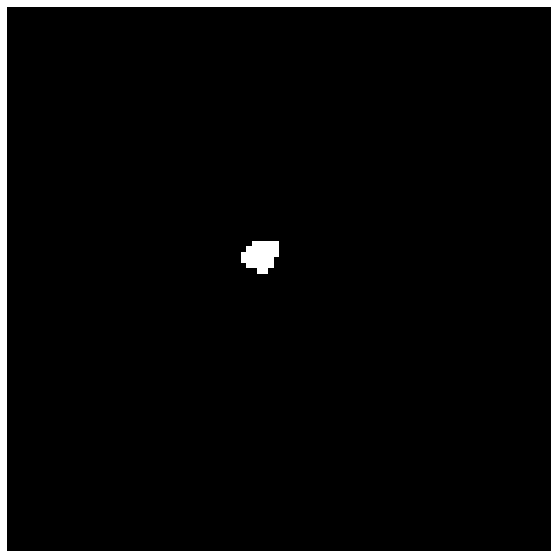

El numero de verdes es: 0
El numero de amarillos es: 0
El numero de rojos es: 31
------------------------------------
-------ES ROJO----------------------
------------------------------------
6


2

In [ ]:
def color_semaforo(nom_archivo):
  #Importando la imagen
  direccion = "imagenes_semaforos/" + nom_archivo
  if(pri == True):  
    print("La direccion es: ")
    print(direccion)
  img = cv2.imread(direccion)

  #Creando un tamaño estandar para las imagenes
  dim = (100, 200)
  img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)

  #En caso de no haber abierto alguna imagen terminar
  if img is None:
    print("Error")
    return r 


  # Cambiando a RGB
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Cambiando de BGR a HSV
  img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)


  # mostrar la imagen normal
  if(plot1 == True):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()


  #kernel para suavizar la imagen
  kernel = np.ones((11,11), np.float32)/121

  #suavizando la imagen
  img_hsv = cv2.filter2D(img_hsv, -1, kernel)
  
  pos = [0, 0]
  img_sat, pos[0], pos[1] = saturacion(img_hsv)
  color = [0, 0, 0]
  img_para_color = np.zeros(np.shape(img_rgb), dtype='uint8')
  color[0] = img_rgb[pos[0], pos[1]][0]
  color[1] = img_rgb[pos[0], pos[1]][1]
  color[2] = img_rgb[pos[0], pos[1]][2]
  for i in range(len(img_sat)):
    for j in range(len(img_sat[0])):
      if(img_sat[i][j]):
        img_para_color[i][j][0] = img_rgb[i][j][0]
        img_para_color[i][j][1] = img_rgb[i][j][1]
        img_para_color[i][j][2] = img_rgb[i][j][2]

  if(pri1 == True): 
    print("El color es: ")
    print(color)
    print("La posicion es: ")
    print(str(pos[0]) + " " + str(pos[1]))
  
  print(img_rgb[100][50])
  n_v, n_a, n_r = f_color(img_para_color)
  if(n_v > 20 and n_r < 30 and n_a < 300):
    if(pri1 == True):
      print("-------------------------------------")
      print("--------ES VERDE---------------------")
      print("-------------------------------------")
      print(1)
    return 0
  elif(n_a > 500 and n_v < 90 and n_r < 90):
    if(pri1 == True):

      print("------------------------------------")
      print("-------ES AMARILLO------------------")
      print("------------------------------------")
      print(2)
    return 1

  elif(n_r > 150 and n_v < 100 and n_a < 300):
    if(pri1 == True):
      print("------------------------------------")
      print("-------ES ROJO----------------------")
      print("------------------------------------")
      print(3)
    return 2
  else:
    if(n_a > n_v and n_a > n_r):
      if(pri1 == True):
        print("------------------------------------")
        print("-------ES AMARILLO------------------")
        print("------------------------------------")
        print(4)
      return 0
    if(n_v > n_a and n_v > n_r):
      if(pri1 == True):
        print("------------------------------------")
        print("-------ES VERDE---------------------")
        print("------------------------------------")
        print(5)
      return 1
    if(n_r > n_a and n_r > n_a):
      if(pri1 == True):
        print("------------------------------------")
        print("-------ES ROJO----------------------")
        print("------------------------------------")
        print(6)
      return 2

  #----------------------------------------#
  #------------FALTA TERMINAR--------------#
  #----------------------------------------#



color_semaforo("r20.jpg")


In [ ]:
 s

In [ ]:
from google.colab import drive
drive.mount('/content/drive')